In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from wordcloud import WordCloud
from nltk.corpus import stopwords
stopwords = [word for word in set(stopwords.words('english'))] # get stopwords from nltk

In [2]:
def preprocess(s, lower=True, strip_punc=True):
    '''
    Input: String, lower(Bool), strip_punc(Bool)
    Output: List of Strings
    '''
    punc = '.-,?<>:;"\'!%'
    if isinstance(s, str):
        s = s.split() # tokenize text
    if lower:
        s = [t.lower() for t in s]
    if strip_punc:
        s = [t.strip(punc) for t in s]
        
    return s

def token_frequency(tokens, tf= None, relative=False):
    """
    Inputs: 
        tokens = List of Strings or None
        tf = dict or None
        relative = Boolean
    Output: 
        Dictionary of a token frequencies
    """
    tf = {} if tf==None else tf
    
    if len(tf) != 0 and relative==True:
        if isinstance(list(tf.items())[0][1], float):
            print('WARNING: Adding raw counts to relative frequency')
            return tf
        
    for token in tokens:
        if token in tf:
            tf[token] += 1
        else:
            tf[token] = 1
    
    if relative:
        total = sum([v for k,v in tf.items()])
        tf = {k:v/total for k, v in tf.items()}
          
    return tf


def calc_percent(headlines):
    total = len(headlines)
    count = 0
    for h in headlines:
        if 'coronavirus' in h or 'covid' in h:
            count += 1
    return round(count/total * 100, 2)

def word_counts(headlines):
    """
    Input: a list of headlines from news articles
    Output: full word counts for all words from the articles
    """
    # define empty dict to collect all words
    tf = {}
    
    # preprocess all headlines
    headlines = headlines.apply(lambda x: preprocess(x))
    
    # calc token frequency of all word tokens in headlines
    headlines.apply(lambda x: token_frequency(x,tf=tf))
    
    # sort tokens by frequency 
    sorted_tokens = sorted(tf.items(), key= lambda x:x[1], reverse=True)
    return sorted_tokens

In [3]:
# read in cnbc articles
df = pd.read_csv('data/cnbc_news.csv',parse_dates=['publish_date'], index_col='publish_date').reset_index()

# drop any rows with null
df = df.dropna()

# preprocess text in headlines
df['headline'] = df['headline'].apply(lambda x: preprocess(x))
df.tail()

,publish_date,headline
5179,2020-05-04,"[listen, live, supreme, court, broadcasts, ora..."
5180,2020-05-04,"[china, has, questions, to, answer, over, the,..."
5181,2020-05-04,"[silver, lake, pumps, $750, million, into, rel..."
5182,2020-05-04,"[tyson, foods, shares, fall, 8, as, production..."
5183,2020-05-04,"[stock, market, live, updates, dow, down, 200,..."


# Top Raw Word Counts Across All Articles

In [4]:
top_word_counts = word_counts(df['headline']) # get raw word counts across all headlines

# remove stop words from word counts
filtered_words = [(w,c) for w,c in top_word_counts if w not in stopwords]

# display top 30 word counts
topn = 30
for word, count in filtered_words[:topn]:
    print("{}: {}".format(word,count))

coronavirus: 2241
says: 845
us: 447
new: 433
stocks: 414
market: 413
live: 408
updates: 358
stock: 342
trump: 329
dow: 307
pandemic: 251
oil: 231
could: 222
cases: 192
here's: 188
york: 186
amid: 176
ceo: 163
million: 160
may: 157
stimulus: 156
points: 145
—: 140
billion: 138
outbreak: 137
amazon: 134
small: 130
crisis: 128
economy: 126


# CNBC Headline Word Cloud

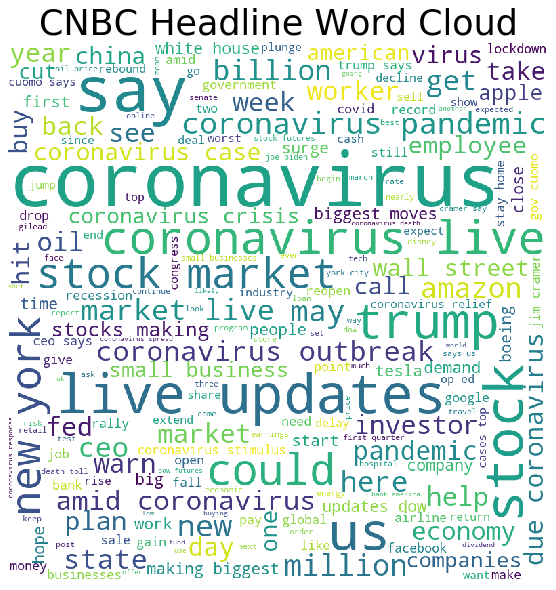

In [5]:
# Show word cloud for all articles
words = ' '.join([word for word_list in df['headline'].values for word in word_list]) # get list of words 

# create a wordcloud object 
newsWordCloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                          stopwords=stopwords,
                min_font_size = 10).generate(words)

# show image of wordcloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("CNBC Headline Word Cloud", fontsize=35)
plt.imshow(newsWordCloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# % of Articles with "Coronavirus" by Day

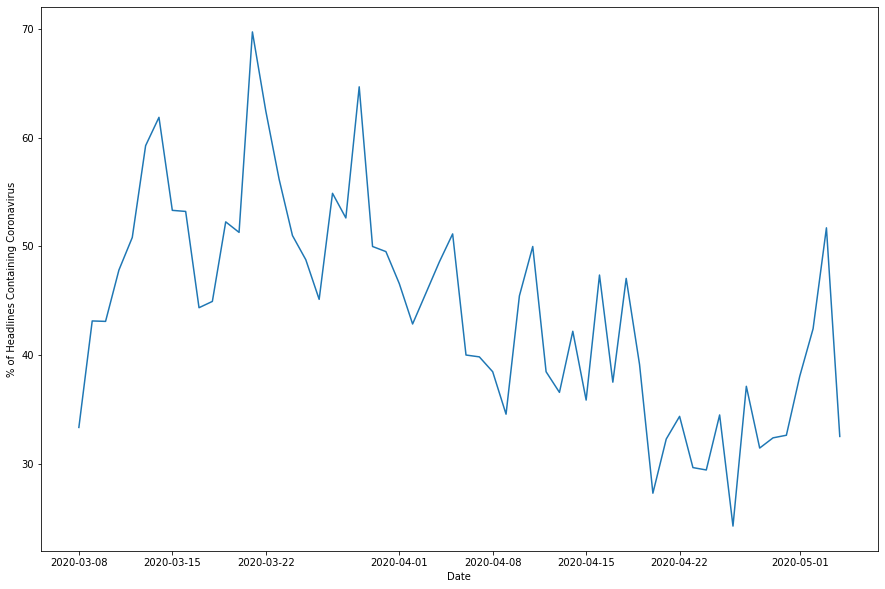

In [10]:
# calc % of headlines that include the word "coronavirus"
percent_per_day = df.groupby('publish_date')['headline'].apply(lambda x: calc_percent(x))[4:]

# plot chart by day
plt.figure(figsize=(15,10))
plt.plot(percent_per_day.index, percent_per_day.values)
plt.xlabel('Date'); plt.ylabel('% of Headlines Containing Coronavirus')
plt.show()

# Number of Coronavirus Articles and VIX Correlation Coefficient

In [7]:
# read in ^VIX data
vix_df = pd.read_csv('data/^VIX.csv',index_col='Date', parse_dates=['Date'])

# start and end dates based on headline dates
start = percent_per_day.index[0]
end = percent_per_day.index[-1]

# get ^VIX daily high based on start and end dates
vix_highs = vix_df.loc[start:end, 'High']

# get daily percents based on weekly days on VIX highs
percents = percent_per_day[vix_highs.index].values

# get vix high values
vix_vals = vix_highs.values

# calc correlation coef between % of COVID-19 articles and VIX Daily Highs
corr = np.corrcoef(vix_vals,percents)[1,0]
print(f'VIX Daily High & % Of COVID-19 Articles per day: \n{round(corr,3)}')

VIX Daily High & % Of COVID-19 Articles per day: 
0.805


# Spearman Rank Correlation and P-Value

In [8]:
# calc spearman rank corr and p-value
r_s = stats.spearmanr(vix_vals,percents)

print("Spearman Rank Coef: ", r_s[0])
print("P-Value Less than 0.05: ", (r_s[1]<0.05)) # if true = value is statistically significant
print("P-Value: ", r_s[1])

Spearman Rank Coef:  0.810169333411563
P-Value Less than 0.05:  True
P-Value:  2.40283193199835e-10


# Simple Linear Regression: VIX vs COVID-19

Line Formula:  VIX = 1.531*Corona + -9.355332257971106
R^2:  0.6481343736064581


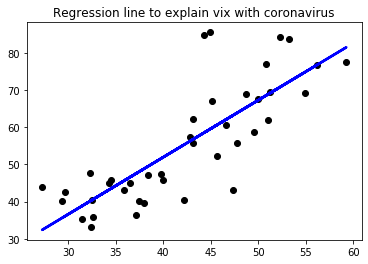

In [9]:
from sklearn.linear_model import LinearRegression

percents = percents.reshape(-1, 1) #reshape x-values

# create regression object and train it 
reg = LinearRegression().fit(percents,vix_vals)

print("Line Formula: ", f'VIX = {round(reg.coef_[0],3)}*Corona + {reg.intercept_}')
print("R^2: ",reg.score(percents,vix_vals)) # print R^2 value

# plot regression line
plt.scatter(percents,vix_vals, color='black') # plot actual values
plt.plot(percents,reg.predict(percents),color='blue', linewidth=2.5) # plot regression line
plt.title('Regression line to explain vix with coronavirus')
plt.show()